In [1]:
import pandas as pd
import io
import requests
from matplotlib import pyplot as plt

url="https://raw.githubusercontent.com/abeasock/coding_assessment/master/patients.csv?_sm_au_=iVV7V2PTJZ3j1f00"
s=requests.get(url).content
patients = pd.read_csv(io.StringIO(s.decode('utf-8')))

url="https://raw.githubusercontent.com/abeasock/coding_assessment/master/appointments.csv?_sm_au_=iVV7V2PTJZ3j1f00"
s=requests.get(url).content
appointments = pd.read_csv(io.StringIO(s.decode('utf-8')))

In [2]:
appointments.head()


,id,appointment_registration,appointment_date,status,sms_reminder
0,613126,2014-06-23T12:26:17Z,2014-06-27T00:00:00Z,Show-Up,No
1,232334,2014-01-17T12:41:37Z,2014-01-27T00:00:00Z,Show-Up,No
2,328426,2014-02-10T14:06:22Z,2014-03-21T00:00:00Z,No-Show,Yes
3,400712,2015-03-25T10:26:31Z,2015-03-31T00:00:00Z,Show-Up,Yes
4,359683,2014-11-06T12:53:01Z,2014-12-01T00:00:00Z,Show-Up,No


In [3]:
patients.head()

,patient_id,age,gender,diabetes,alcoholism,hypertension,handicap,smokes,tuberculosis
0,395728,30,F,0,0,0,0,0,0
1,799589,5,F,0,0,0,0,0,0
2,401681,22,F,0,0,0,0,0,0
3,543473,62,M,0,0,1,0,0,0
4,370260,20,F,0,0,0,0,0,0


In [4]:
patient_appt = patients.merge(appointments, how='inner', left_on='patient_id', right_on='id')

In [5]:
patient_appt['new_status'] = patient_appt['status'].apply(lambda x: 1 if x=='Show-Up' else 0)
patient_appt['new_gender'] = patient_appt['gender'].apply(lambda x: 1 if x=='F' else 0)
patient_appt.head()
patient_appt.new_gender.value_counts()

1    200445
0     99455
Name: new_gender, dtype: int64

In [6]:
#n=len(patient_appt.unique(patient_appt['patient_id']))
n1=patient_appt.nunique(axis=0)

In [7]:
print("unique count:\n", n1)

unique count:
 patient_id                  299897
age                            109
gender                           2
diabetes                         2
alcoholism                       2
hypertension                     2
handicap                         5
smokes                           2
tuberculosis                     2
id                          299897
appointment_registration    295326
appointment_date               534
status                           2
sms_reminder                     2
new_status                       2
new_gender                       2
dtype: int64


In [8]:
patient_appt.groupby(['status','sms_reminder']).id.nunique()


status   sms_reminder
No-Show  No               38904
         Yes              51792
Show-Up  No               89605
         Yes             119598
Name: id, dtype: int64

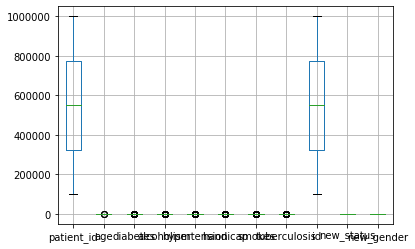

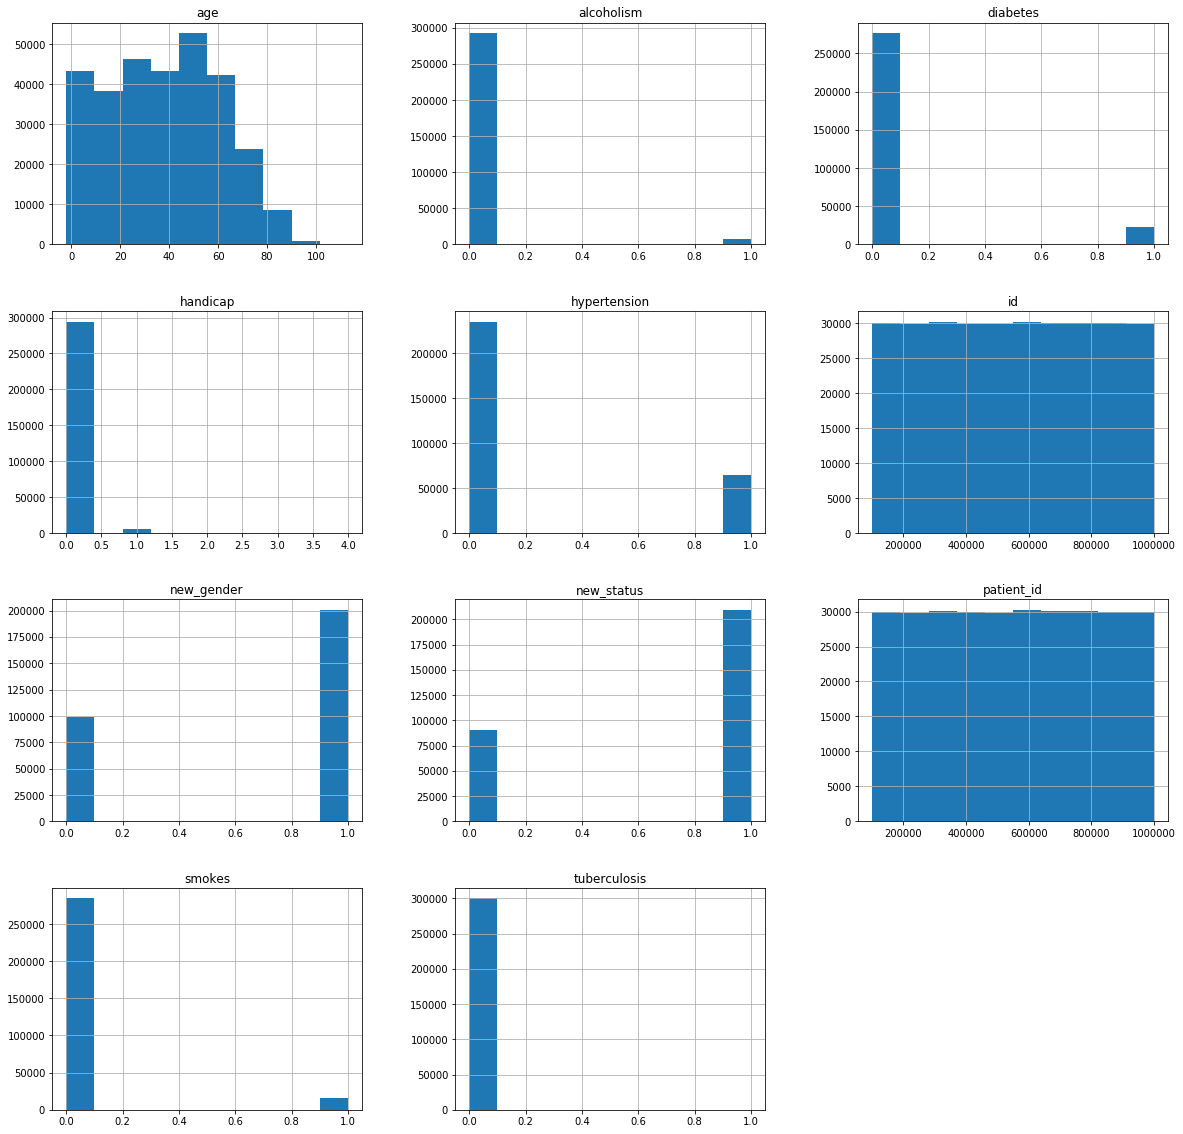

In [9]:
patient_appt.boxplot()
patient_appt.hist(figsize=(20,20));

In [10]:
X = patient_appt[['age','new_gender','diabetes','alcoholism','hypertension','handicap','smokes','tuberculosis']]
y = patient_appt['new_status']
X_d = X.fillna(X.median())

In [11]:
X_d.head()

,age,new_gender,diabetes,alcoholism,hypertension,handicap,smokes,tuberculosis
0,30,1,0,0,0,0,0,0
1,5,1,0,0,0,0,0,0
2,22,1,0,0,0,0,0,0
3,62,0,0,0,1,0,0,0
4,20,1,0,0,0,0,0,0


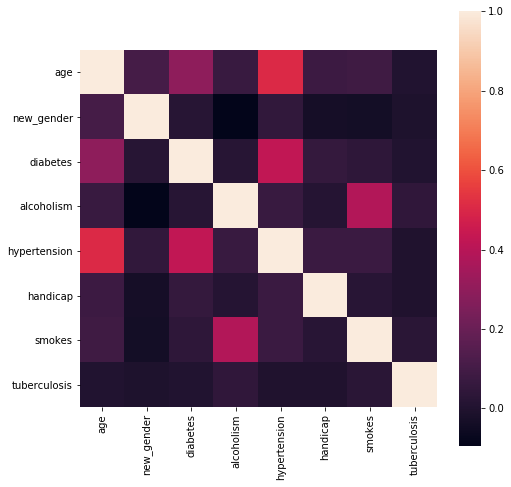

In [12]:
%matplotlib inline
import seaborn as sns
corr=X_d.corr()
plt.figure(figsize = (8,8))
sns.heatmap(corr,vmax=1,square=True)

In [13]:

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_d)
X_Sscaled = scaler.transform(X_d)

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_Sscaled,y,random_state=42, stratify=y)

In [15]:
y_train.value_counts()

1    156903
0     68022
Name: new_status, dtype: int64

In [17]:

#Creating polynomial terms with degree 2 for regression.
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=2).fit(X_train)
X_train_poly = poly.transform(X_train)
X_test_poly = poly.transform(X_test)

In [18]:
#Building logistic regression model with C value of 0.01 and checking training and test accuracies.
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(C=0.01,random_state=0)
logreg.fit(X_train,y_train)
print("Training set score: {:.3f}".format(logreg.score(X_train, y_train)))
print("Test set score: {:.3f}".format(logreg.score(X_test, y_test)))

Training set score: 0.698
Test set score: 0.698


In [19]:
from sklearn import metrics
from math import sqrt
# Make Predictions
logreg_predicted = logreg.predict(X_test)
probas = logreg.predict_proba(X_test)
logreg_preds = probas[:,1]
logreg_fpr, logreg_tpr, logreg_threshold = metrics.roc_curve(y_test, logreg_preds)

In [20]:
#Building polynomial logistic regression model with C value of 10 and checking training and test accuracies.
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(C=10,random_state=0)
logreg.fit(X_train_poly,y_train)
print("Training set score: {:.3f}".format(logreg.score(X_train_poly, y_train)))
print("Test set score: {:.3f}".format(logreg.score(X_test_poly, y_test)))

Training set score: 0.698
Test set score: 0.697


C:\Users\hahara\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [21]:

#Building Random Forest model and checking training and test accuracies.
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=50,max_depth=40,random_state=0)
rfc.fit(X_train,y_train)
print("Training set score: {:.3f}".format(rfc.score(X_train, y_train)))
print("Test set score: {:.3f}".format(rfc.score(X_test, y_test)))

Training set score: 0.700
Test set score: 0.696


In [22]:
# Make Predictions
rfc_predicted = rfc.predict(X_test)
probas = rfc.predict_proba(X_test)
rfc_preds = probas[:,1]
rfc_fpr, rfc_tpr, rfc_threshold = metrics.roc_curve(y_test, rfc_preds)

In [23]:

#Building Decision Tree model and checking training and test accuracies.
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier(random_state = 0)
dtc.fit(X_train,y_train)
print("Training set score: {:.3f}".format(dtc.score(X_train, y_train)))
print("Test set score: {:.3f}".format(dtc.score(X_test, y_test)))

Training set score: 0.700
Test set score: 0.695


In [24]:
# Top 5 most important features
print ("Feature Importance (Top 5): ")
print (pd.DataFrame(dtc.feature_importances_, columns = ["Imp"], index = X_d.columns).sort_values(['Imp'], ascending = False).head(5))

Feature Importance (Top 5): 
                   Imp
age           0.721920
handicap      0.057180
new_gender    0.053329
smokes        0.053016
hypertension  0.047767


In [25]:
# Make Predictions
dtc_predicted = dtc.predict(X_test)
probas = dtc.predict_proba(X_test)
dtc_preds = probas[:,1]
dtc_fpr, dtc_tpr, dtc_threshold = metrics.roc_curve(y_test, dtc_preds)

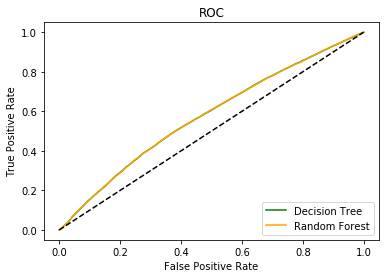

In [28]:
#Model Comparison    

plt.plot(dtc_fpr, dtc_tpr, label='Decision Tree', color='green')
plt.plot(rfc_fpr, rfc_tpr, label='Random Forest', color='orange')

plt.plot([0, 1], [0, 1],'r--', color='black')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")